***STAGE 2: DATA PRE-PROCESSING***

# **1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

# **2. Load Data** <br>
Data yang digunakan yaitu [Used Car Auction Prices](https://www.kaggle.com/datasets/tunguz/used-car-auction-prices) dari kaggle.com.


In [2]:
df = pd.read_csv('./car_prices.csv', on_bad_lines='skip')

# **3. Data Pre-processing** <br>

## 3.1. Handling Duplicated Data

In [3]:
df.duplicated().sum()

0

Tidak ada data duplikat.

## 3.2. Handling Missing Values

### 3.2.1 Drop Missing Values

In [4]:
mv = df.isnull().sum()
tmv = df.isnull().count()

pmv = mv*100/tmv

mdf = pd.concat([mv, pmv], axis=1)
mdf.columns = ['Missing Value Total', 'Missing Value Percentage (%)']
mdf.reset_index(inplace=True)
# mdf

In [5]:
col_mv = mdf[mdf['Missing Value Percentage (%)'] < 2.5]['index'] # kolom dengan missing value < 2.5 akan kita drop barisnya
# col_mv

In [6]:
# Setelah drop missing value dari kolom yang persentase missing value < 2.5 %
cols = col_mv.values
for i in cols:
    df = df[~(df[i].isnull())]
df.isna().sum()

year                0
make                0
model               0
trim                0
body                0
transmission    61324
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

In [7]:
# df.shape

### 3.2.2 Fill Missing Value in Transmission Column

In [8]:
# before filling missing value
df['transmission'].isnull().sum()

61324

In [9]:
# after filling missing value
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])
df['transmission'].isnull().sum()

0

In [10]:
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='transmission', common_norm=False, palette="bright");

## 3.3. Recategorization High Cardinality in Categorical Features

In [11]:
def top_value(df, column, threshold=95):
    grouped = df.groupby(column).agg({column:'count'})
    grouped.columns = ['counts']
    grouped = grouped.reset_index().sort_values('counts', ascending=False)
    grouped['%'] = round(grouped['counts'] / grouped['counts'].sum() * 100, 2)

    grouped['cumulative %'] = grouped['%'].cumsum()

    result = grouped[grouped['cumulative %'] <= threshold]
    return result[[column, 'cumulative %']].reset_index(drop=True)

### 3.3.1 Color

In [12]:
top_value(df, 'color', 96)

,color,cumulative %
0,black,19.98
1,white,39.06
2,gray,54.05
3,silver,68.95
4,blue,78.04
5,red,85.84
6,—,90.41
7,gold,92.37
8,green,94.31
9,beige,95.92


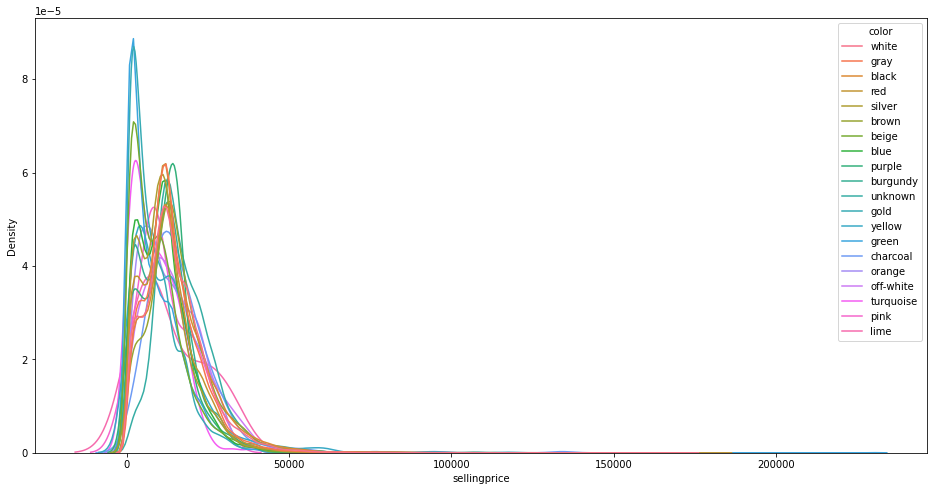

In [13]:
# mengganti nilai - menjadi unknown pada kolom color
df.color = df.color.replace('—', 'unknown')

# KDE color_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='color', common_norm=False);

In [14]:
def color_category(x):
  if x['color'] == 'black':
    val = 'black'
  elif x['color'] == 'white':
    val = 'white'
  elif x['color'] == 'gray':
    val = 'gray'
  elif x['color'] == 'silver':
    val = 'silver'
  elif x['color'] == 'blue':
    val = 'blue'
  elif x['color'] == 'red':
    val = 'red'
  elif x['color'] == 'gold':
    val = 'gold'
  elif x['color'] == 'green':
    val = 'green'
  elif x['color'] == 'beige':
    val = 'beige'
  else:
    val = 'others'
  return val

df['color'] = df.apply(lambda x: color_category(x), axis=1)

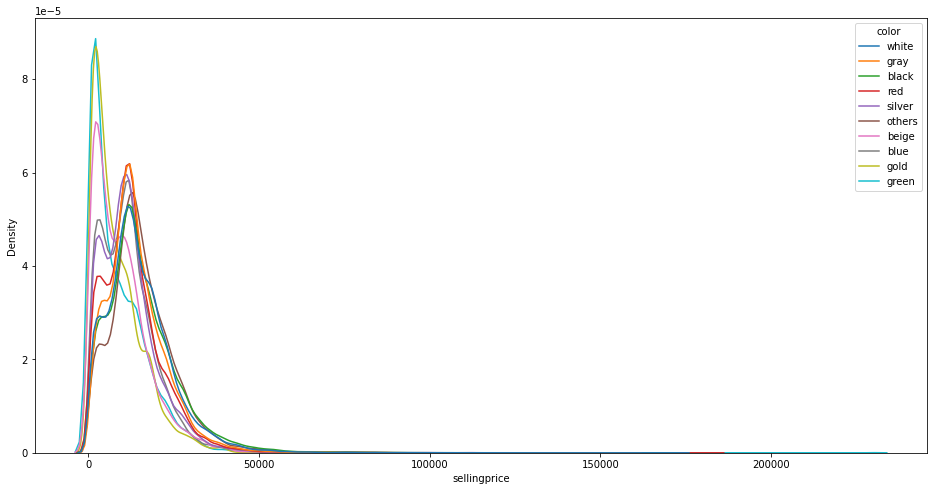

In [15]:
# KDE color_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='color', common_norm=False);

### 3.3.2 Interior

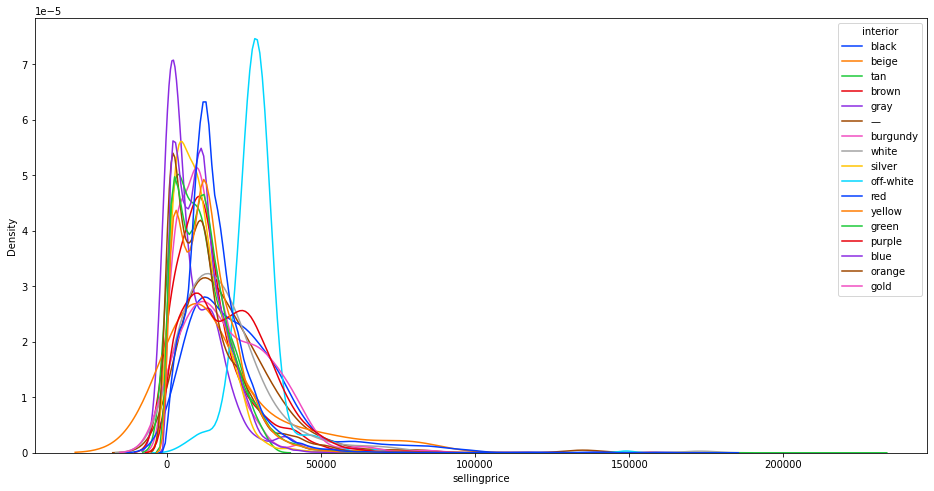

In [16]:
top_value(df, 'interior', 96)

# KDE interior_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='interior', common_norm=False, palette="bright");

In [17]:
# Rekategori kolom interior: black, blue, brown, off-white, red, beige, blue, gray (lihat sub bagian 3.2.4)
def interior_category(x):
    if x['interior'] == 'black':
        interior = 'black'
    elif x['interior'] == 'beige':
        interior = 'beige'
    elif x['interior'] == 'gray':
        interior = 'gray'
    elif x['interior'] == 'tan':
        interior = 'tan'
    else:
        interior= 'others'
    return interior

# membuat kolom baru yaitu kolom interior_new menggunakan fungsi interior_category
df['interior'] = df.apply(lambda x: interior_category(x), axis=1)

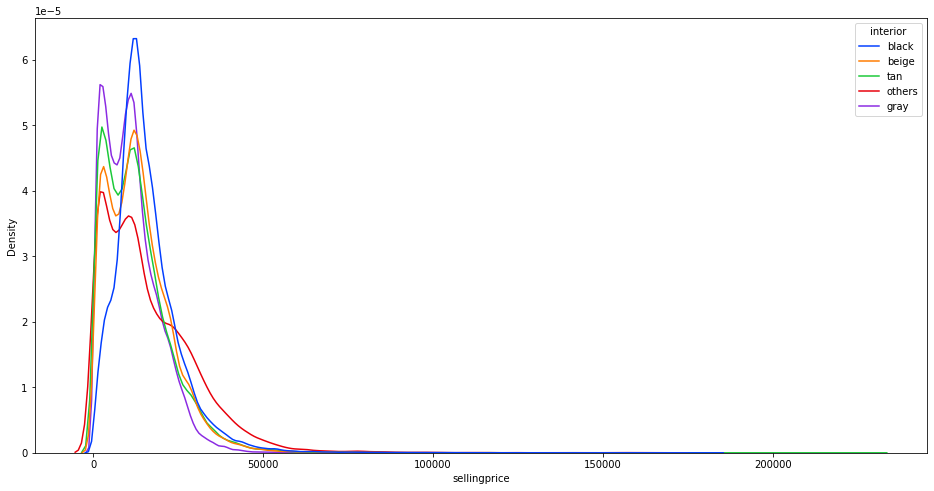

In [18]:
# KDE interior_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='interior', common_norm=False, palette="bright");

## 3.4. Handling Inconsistent Values & Recategorization High Cardinality

### 3.4.1 Make

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


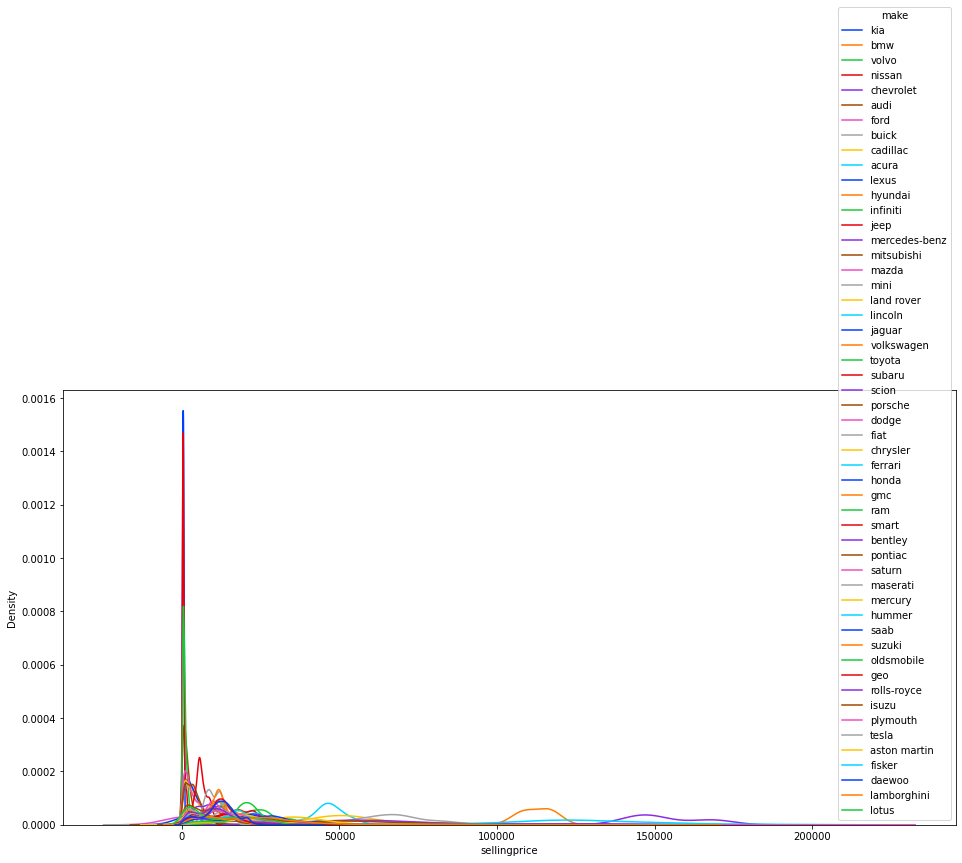

In [19]:
# memperbaiki nilai yang berbeda karakter huruf (kapital, lowercase) pada kolom make 
df['make'] = df['make'].str.lower()
df['make'].nunique()

# KDE make_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='make', common_norm=False, palette="bright");

In [20]:
x = top_value(df, 'make', 95)
x

,make,cumulative %
0,ford,17.22
1,chevrolet,28.24
2,nissan,38.19
3,toyota,45.50
4,dodge,51.14
5,honda,56.08
6,hyundai,60.10
7,bmw,63.87
8,kia,67.22
9,chrysler,70.39


In [21]:
def make_category(x):
  if x['make'] == 'ford':
    val = 'ford'
  elif x['make'] == 'chevrolet':
    val = 'chevrolet'
  elif x['make'] == 'nissan':
    val = 'nissan'
  elif x['make'] == 'toyota':
    val = 'toyota'
  elif x['make'] == 'dodge':
    val = 'dodge'
  elif x['make'] == 'honda':
    val = 'honda'
  elif x['make'] == 'hyundai':
    val = 'hyundai'
  elif x['make'] == 'bmw':
    val = 'bmw'
  elif x['make'] == 'kia':
    val = 'kia'    
  elif x['make'] == 'chrysler':
    val = 'chrysler'
  elif x['make'] == 'mercedes-benz':
    val = 'mercedes-benz'
  elif x['make'] == 'infiniti':
    val = 'infiniti'
  elif x['make'] == 'jeep':
    val = 'jeep'
  elif x['make'] == 'volkswagen':
    val = 'volkswagen'
  elif x['make'] == 'lexus':
    val = 'lexus'
  elif x['make'] == 'gmc':
    val = 'gmc'
  elif x['make'] == 'mazda':
    val = 'mazda'
  elif x['make'] == 'cadillac':
    val = 'cadillac'
  elif x['make'] == 'acura':
    val = 'acura'
  elif x['make'] == 'audi':
    val = 'audi'
  elif x['make'] == 'lincoln':
    val = 'lincoln'
  elif x['make'] == 'subaru':
    val = 'subaru'
  elif x['make'] == 'buick':
    val = 'buick'
  elif x['make'] == 'ram':
    val = 'ram'
  else:
    val = 'others'
  return val

# Membuat kolom baru yaitu kolom make_new menggunakan fungsi make_category
df['make'] = df.apply(lambda x: make_category(x), axis=1)

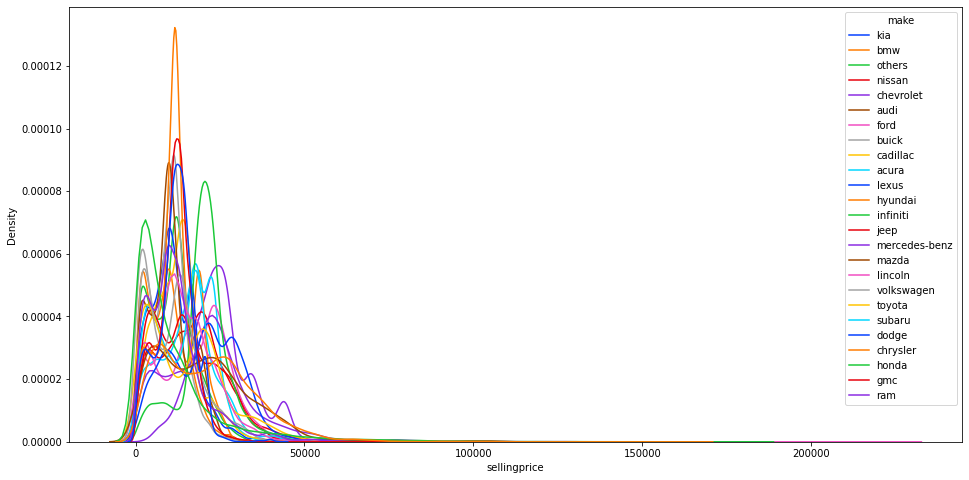

In [22]:
# KDE make_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='make', common_norm=False, palette="bright");

### 3.4.2 Body

Jumlah unique value sebelum handling: 86
Jumlah unique value setelah handling: 45


C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


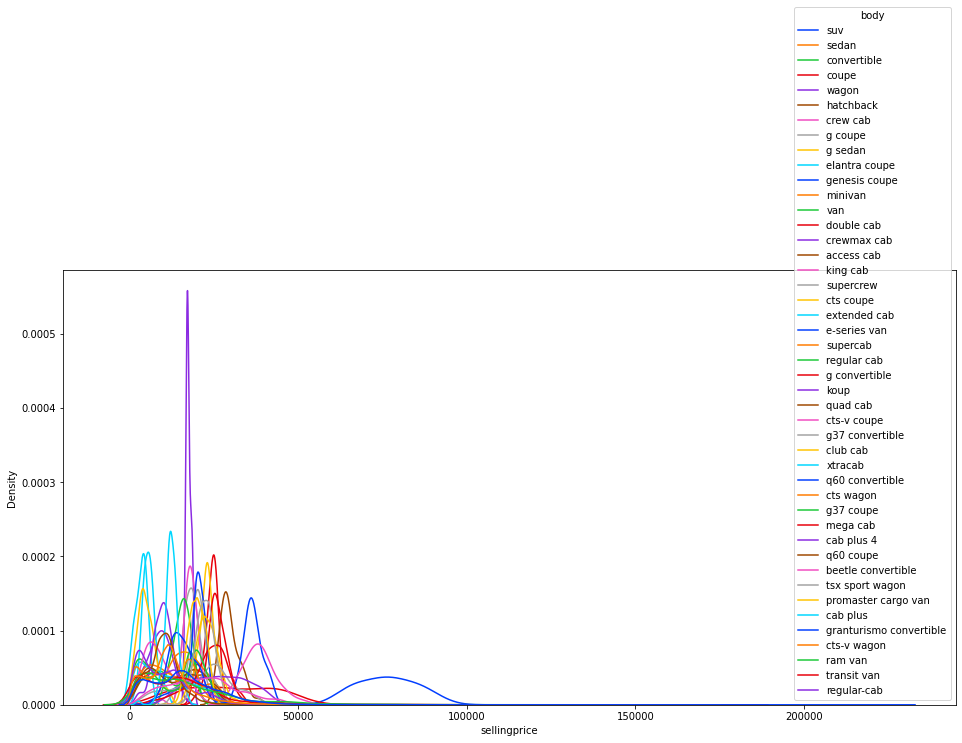

In [23]:
# Unique value pada kolom body (sebelum handling)
print('Jumlah unique value sebelum handling:', df.body.nunique())

# Memperbaiki nilai yang berbeda karakter huruf (kapital, lowercase) pada kolom body 
df['body'] = df['body'].str.lower()
print('Jumlah unique value setelah handling:', df.body.nunique())

# print('\n', df['body'].unique())

# KDE body_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='body', common_norm=False, palette="bright");

In [24]:
top_value(df, 'body')

,body,cumulative %
0,sedan,44.31
1,suv,70.64
2,hatchback,75.46
3,minivan,80.12
4,coupe,83.35
5,crew cab,86.35
6,wagon,89.29
7,convertible,91.20
8,supercrew,92.86
9,g sedan,94.25


In [25]:
def body_category(x):
    if x['body'] == 'sedan':
        val = 'sedan'
    elif x['body'] == 'suv':
        val = 'suv'
    elif x['body'] == 'hatchback':
        val = 'hatchback'
    elif x['body'] == 'minivan':
        val = 'minivan'
    elif x['body'] == 'coupe':
        val = 'coupe'
    elif x['body'] == 'crew cab':
        val = 'crew cab'
    elif x['body'] == 'wagon':
        val = 'wagon'
    elif x['body'] == 'convertible':
        val = 'convertible'
    elif x['body'] == 'supercrew':
        val = 'supercrew'
    elif x['body'] == 'g sedan':
        val = 'g sedan'
    else:
        val = 'others'
    return val

# Membuat kolom baru yaitu kolom body_new menggunakan fungsi make_category
df['body'] = df.apply(lambda x: body_category(x), axis=1)

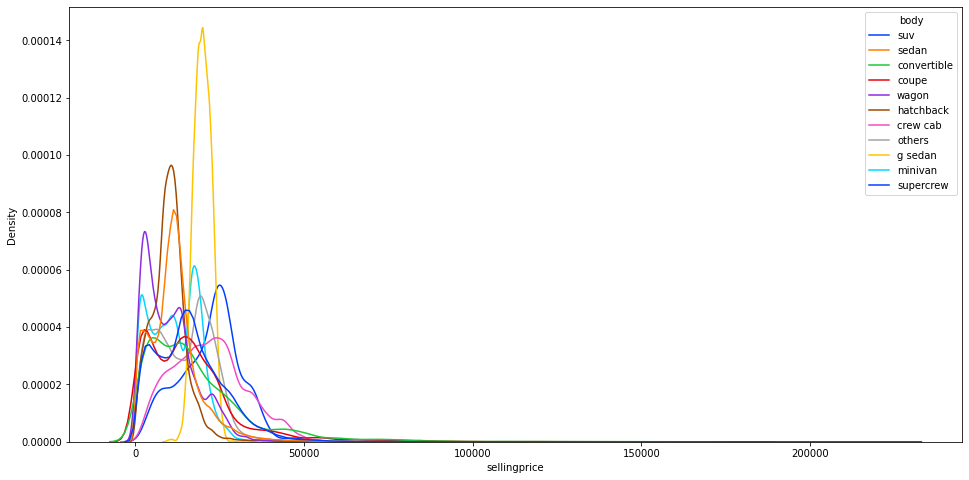

In [26]:
# KDE body_new vs sellingprice
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df, x='sellingprice', hue='body', common_norm=False, palette="bright");

## 3.5. Feature Transformation <br>
Log Transformation pada feature odometer. Kami melakukan transoformasi terlebih dulu sebelum melakukan handling outlier. Jika kita melakukan handling outlier terlebih dulu, maka kemungkinan data yang akan dibuang lebih banyak. Oleh karena itu, kami melakukan log transformation terlebih dulu dengan harapan data semakin terdistribusi dengan normal sehingga data yang terindikasi outlier lebih sedikit.

In [27]:
# # KDE sebelum transformation
# cols = ['odometer']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

### 3.5.1 Transformasi dengan Pangkat 1/3

In [28]:
df['odometer_pow'] = df['odometer'].apply(lambda x : x**(1/3))
print('Skew value:', df['odometer_pow'].skew())

# # KDE setelah transformation dengan pangkat 1/3
# cols = ['odometer_pow']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.0656155379397687


### 3.5.2 PowerTransformer <br>
[PowerTransformer](https://medium.com/towards-data-science/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94)

In [29]:
# Transformasi dengan PowerTransformer
from sklearn.preprocessing import PowerTransformer
df['odometer_pt'] = PowerTransformer().fit_transform(df['odometer'].values.reshape(len(df), 1))
print('Skew value:', df['odometer_pt'].skew())

# # KDE setelah Transformasi dengan PowerTransformer
# cols = ['odometer_pt']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.012277514291040147


Berdasarkan nilai skew, kami memilih menggunakan hasil transformasi dari PowerTransformer (odometer_pt)

In [30]:
# Drop kolom odometer_pow
df = df.drop(columns='odometer_pow')

In [31]:
# Normalisasi year
from sklearn.preprocessing import MinMaxScaler, StandardScaler
df['year_norm'] = MinMaxScaler().fit_transform(df['year'].values.reshape(len(df), 1))

## 3.6. Handling Outliers <br>
Handling outlier dilakukan pada kolom `odometer_pt` dan `sellingprice`.

In [32]:
# Boxplot sebelum handling outlier
cols = ['odometer_pt', 'sellingprice']

# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

rows_before_filt = len(df)
print('Jumlah Baris sebelum filter:', rows_before_filt, '\n')

Jumlah Baris sebelum filter: 533660 



In [33]:
# # Handling outlier dengan z-score
# cols = ['odometer_pt', 'sellingprice']

# filtered_entries = np.array([True] * len(df))

# for col in cols:
#     zscore = abs(stats.zscore(df[col]))                       # hitung absolute z-scorenya
#     filtered_entries = (zscore < 3) & filtered_entries        # keep yang kurang dari 3 absolute z-scorenya
    
# df = df[filtered_entries]                                     # filter, cuma ambil yang z-scorenya dibawah 3

# # Total baris yang dibuang
# rows_after_filt = len(df)
# diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
# print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
# print(f'Persentase outlier yang dibuang:', diff)

In [34]:
# Handling outlier dengan IQR odometer_pt
Q1 = df['odometer_pt'].quantile(0.25)
Q3 = df['odometer_pt'].quantile(0.75)
IQR = Q3-Q1

low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)
filtered_entries = (df['odometer_pt']>= low_limit) & (df['odometer_pt']<= high_limit)
df = df[filtered_entries]

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah baris setelah memfilter outlier: 531434
Persentase outlier yang dibuang: 0.42


In [35]:
# Handling outlier dengan IQR sellingprice
Q1 = df['sellingprice'].quantile(0.25)
Q3 = df['sellingprice'].quantile(0.75)
IQR = Q3-Q1

low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)
filtered_entries = (df['sellingprice']>= low_limit) & (df['sellingprice']<= high_limit)
df = df[filtered_entries]

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah baris setelah memfilter outlier: 515386
Persentase outlier yang dibuang: 3.42


In [36]:
# # Boxplot setelah PowerTransformer dan handlingoutlier
# cols = ['odometer_pt', 'sellingprice']
# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

In [37]:
# # KDE odometer_pt dan sellingprice setelah handling outlier
# cols = ['odometer_pt', 'sellingprice']
# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

## 3.7 Feature Extraction

In [38]:
# # Transform kolom saledate
# df['saledate'] = df['saledate'].apply(lambda x:re.search('(\w+\s\d{2}\s\d{4})',x).group(1))
# df['saledate'] = pd.to_datetime(df['saledate'], format='%b %d %Y')
# df["is_weekend"] = np.where(df["saledate"].dt.weekday >= 6, 1, 0)

## 3.9. Feature Selection
- pertama pakai color
- setelah lihat feature imporatance maka color dibuang dan akurasinya tetap sama

In [39]:
# Feature yang dipilih untuk memprediksi sellingprice
df = df[['year', 'odometer_pt', 'condition',
         'make', 'body', 'interior',
         'sellingprice']]

# Buang sellingprice bernilai 1
df = df[~(df['sellingprice']==1)]

## 3.10. Feature encoding

### 3.10.1 Label Encoding

In [41]:
# # Label encoding -> kolom transmission
# mapping_trans = {
#     'automatic' : 0,
#     'manual' : 1
# }

# df['transmission'] = df['transmission'].map(mapping_trans)

### 3.10.2 OHE

In [42]:
cols_OHE = ['make',  'body', 'interior']

for i in cols_OHE:
    onehots = pd.get_dummies(df[i], prefix=i, drop_first=True)  # drop_first=True utk menghindari multicollinearity
    df = df.join(onehots)
    

# kolom yang telah dilakukan OHE akan di-drop
df = df.drop(columns=cols_OHE)

In [43]:
df.columns

Index(['year', 'odometer_pt', 'condition', 'sellingprice', 'make_audi',
       'make_bmw', 'make_buick', 'make_cadillac', 'make_chevrolet',
       'make_chrysler', 'make_dodge', 'make_ford', 'make_gmc', 'make_honda',
       'make_hyundai', 'make_infiniti', 'make_jeep', 'make_kia', 'make_lexus',
       'make_lincoln', 'make_mazda', 'make_mercedes-benz', 'make_nissan',
       'make_others', 'make_ram', 'make_subaru', 'make_toyota',
       'make_volkswagen', 'body_coupe', 'body_crew cab', 'body_g sedan',
       'body_hatchback', 'body_minivan', 'body_others', 'body_sedan',
       'body_supercrew', 'body_suv', 'body_wagon', 'interior_black',
       'interior_gray', 'interior_others', 'interior_tan'],
      dtype='object')

In [44]:
df.shape

(515384, 42)

In [45]:
# df.isna().sum()

## 3.11 Train-Test Split Data

In [46]:
# Split Dataset
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.3, random_state=100)

print('Total training data:', training_data.shape[0])
print('Total testing data :', testing_data.shape[0])

Total training data: 360768
Total testing data : 154616


In [47]:
# # Save to csv
# training_data.to_csv('train_data.csv', index=False)
# testing_data.to_csv('test_data.csv', index=False)

In [48]:
# Splitting data

X_train = training_data.drop(columns=['sellingprice'])
y_train =  training_data['sellingprice']

X_test = testing_data.drop(columns=['sellingprice'])
y_test = testing_data['sellingprice']

In [49]:
# Standarisasi Features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform (X_test)

In [50]:
import matplotlib.pyplot as plt
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(10, 8), color='#008B8B', edgecolor='black')
    ax.set_facecolor("#F5F5F5")
    
    ax.invert_yaxis()
    
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score', fontsize=15, fontweight='bold')

# 4. RandomForest

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(random_state=100)
# rf.fit(X_train, y_train)

# # Eval Train
# y_pred_train = rf.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = rf.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

In [52]:
X = training_data.drop('sellingprice', axis=1)
# show_feature_importance(rf)

# 5. XGBoost

In [53]:
from xgboost import XGBRegressor
# xg = XGBRegressor()
# xg.fit(X_train, y_train)

# # Eval Train
# y_pred_train = xg.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = xg.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

In [54]:
# show_feature_importance(xg)

In [55]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import numpy as np
# #Menjadikan ke dalam bentuk dictionary
# hyperparameters = {
#                     'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#                     'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
#                     'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'tree_method' : ['auto', 'exact', 'approx', 'hist'],

#                     'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

#                     'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
#                     }

# # Init
# xg = XGBRegressor(random_state=42)
# xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, return_train_score=True)
# xg_tuned.fit(X_train,y_train)


# # Model Evaluation
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Eval Train
# y_pred_train = xg_tuned.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*75)

# # Eval Test
# y_pred_test = xg_tuned.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

# 6. Lasso

In [56]:
# from sklearn.linear_model import Lasso
# lasso = Lasso()
# lasso.fit(X_train, y_train)

# # Eval Train
# y_pred_train = lasso.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = lasso.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

# 7. Ridge

In [57]:
# from sklearn.linear_model import Ridge
# ridge = Ridge()
# ridge.fit(X_train, y_train)

# # Eval Train
# y_pred_train = ridge.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = ridge.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

# 8. Decision Tree

In [58]:
# from sklearn.tree import DecisionTreeRegressor

# dt = DecisionTreeRegressor()
# dt.fit(X_train, y_train)

# # Eval Train
# y_pred_train = dt.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = dt.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

In [59]:
# show_feature_importance(dt)

# 9. Adaboost

In [60]:
# from sklearn.ensemble import AdaBoostRegressor

# ada = AdaBoostRegressor(random_state=42)
# ada.fit(X_train, y_train)

# # Eval Train
# y_pred_train = ada.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = ada.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

# 10. LGBM

In [61]:
from lightgbm import LGBMRegressor
# lgbm = LGBMRegressor(n_estimators=198)
# lgbm.fit(X_train, y_train)


# # Eval Train
# y_pred_train = lgbm.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = lgbm.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

C:\Users\USER\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\USER\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\USER\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [62]:
# show_feature_importance(lgbm)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
learning_rate = [0.9]
min_data_in_leaf = [10]
min_sum_hessian_in_leaf = [1, 10, 100]
n_estimators = [10, 100, 500, 1000]

hyperparameters = dict(n_estimators = n_estimators,
                        learning_rate=learning_rate,
                        min_data_in_leaf=min_data_in_leaf,
                        min_sum_hessian_in_leaf=min_sum_hessian_in_leaf
                      )

# Inisialisasi Model
lgbm = LGBMRegressor()
lgbm_tuned = RandomizedSearchCV(lgbm, hyperparameters, n_iter=15, cv=5, random_state=100, scoring='r2')
lgbm_tuned.fit(X_train, y_train)


# Eval Train
y_pred_train = lgbm_tuned.predict(X_train)
print('Train Score')
print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
print('='*50)

# Eval Test
y_pred_test = lgbm_tuned.predict(X_test)
print('Test Score')
print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=15. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current v

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Cu

In [ ]:
show_feature_importance(lgbm_tuned.best_estimator_)

# 11. Linear Regression

In [ ]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)

# # Eval Train
# y_pred_train = regressor.predict(X_train)
# print('Train Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_train, y_train)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_train, y_train, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_train, y_train)) # Explained variance score: 1 is perfect prediction
# print('='*50)

# # Eval Test
# y_pred_test = regressor.predict(X_test)
# print('Test Score')
# print("MAE: %.2f" % mean_absolute_error(y_pred_test, y_test)) # The MAE
# print("RMSE: %.2f" % mean_squared_error(y_pred_test, y_test, squared=False)) # The RMSE
# print('R2 score: %.2f' % r2_score(y_pred_test, y_test)) # Explained variance score: 1 is perfect prediction